In [30]:
import glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import pearsonr
from PIL import Image
from tqdm import tqdm

from model_training.measures import accuracy, f1_score

In [24]:
MODELS_PATH = '../models'
CLASS_LABELS = os.listdir('../data/tsrc_spectrograms_cleaned/train')

## Compare the results for different techniques

In [25]:
results = {}

for predictions_file in glob.glob(f'{MODELS_PATH}/**/predictions.csv', recursive=True):
    df = pd.read_csv(predictions_file)
    y_true = df["y_true"].values
    y_pred = df["y_pred"].values

    accuracy_score = accuracy(y_true, y_pred)
    f1_score_value = f1_score(y_true, y_pred)
    results[Path(predictions_file).parent.stem] = {
        'accuracy': accuracy_score,
        'f1_score': f1_score_value
    }

results_df = pd.DataFrame(results).T
results_df

,accuracy,f1_score
resnet18_tsrc_spectrograms,0.378577,0.372848
simple_cnn_tsrc_spectrograms,0.803680,0.808253
simple_cnn_tsrc_spectrograms_cleaned,0.823534,0.825102
simple_cnn_tsrc_spectrograms_cleaned_sharpened,0.824599,0.826996
simple_cnn_wo_red_channel_tsrc_spectrograms,0.784020,0.786697


## Draw classification histograms

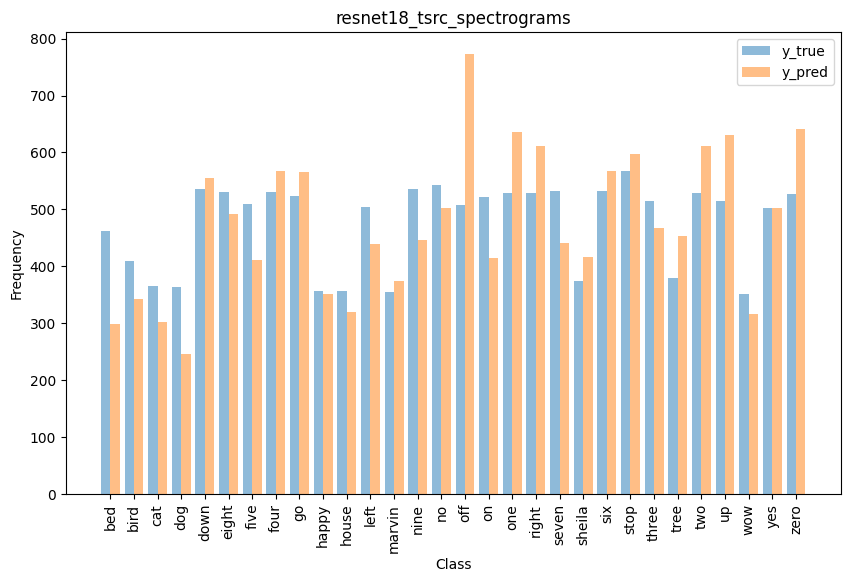

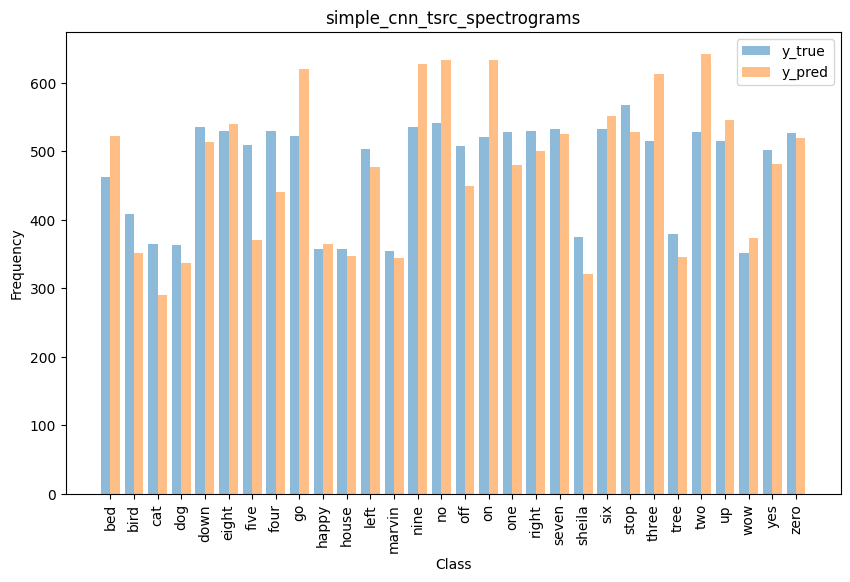

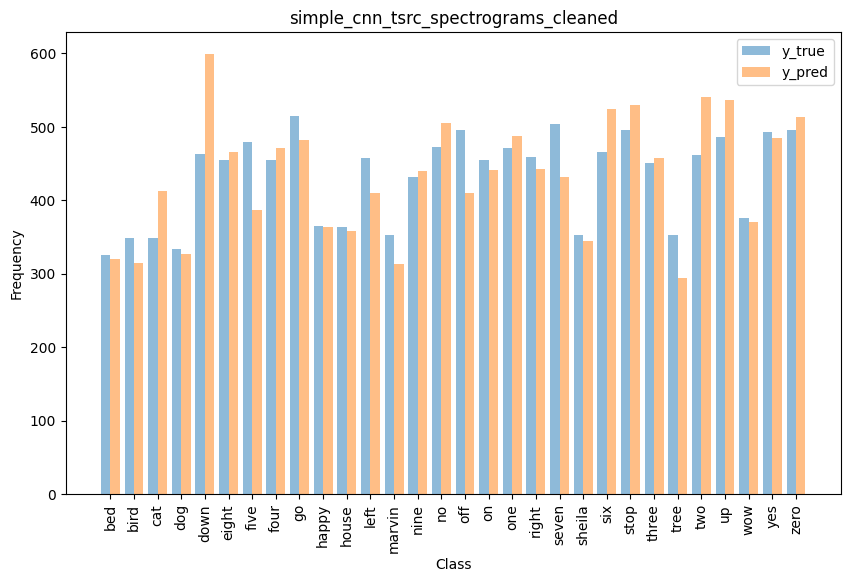

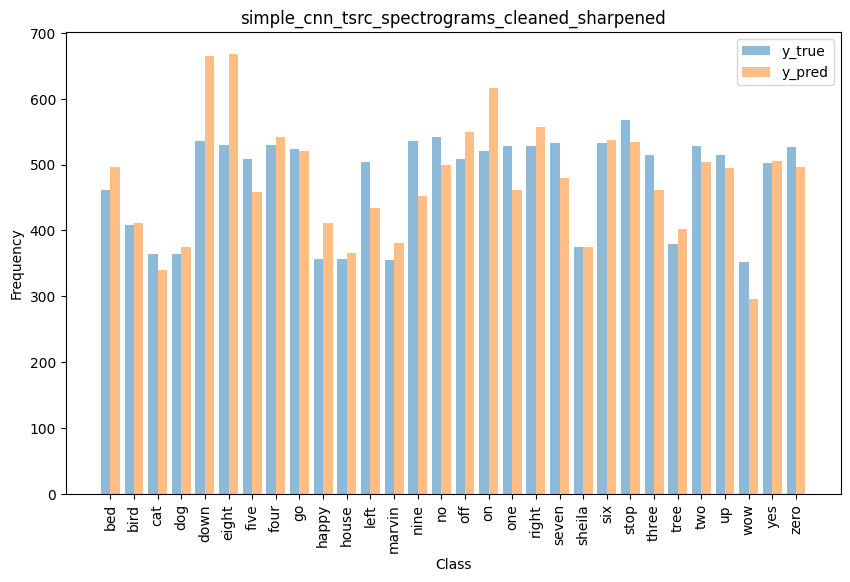

""


In [23]:
import numpy as np


results = {}

for predictions_file in glob.glob(f'{MODELS_PATH}/**/predictions.csv', recursive=True):
    df = pd.read_csv(predictions_file)
    y_true = df["y_true"].values
    y_pred = df["y_pred"].values

    bins = np.arange(len(CLASS_LABELS) + 1) - 0.5
    plt.figure(figsize=(10, 6))
    plt.hist([y_true, y_pred], bins=bins, alpha=0.5, label=['y_true', 'y_pred'])
    plt.xticks(ticks=np.arange(len(CLASS_LABELS)), labels=CLASS_LABELS, rotation=90)
    plt.title(Path(predictions_file).parent.stem)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

results_df = pd.DataFrame(results).T
results_df

## The correlation between RGB channels and classification results

### Before cleaning

In [42]:
image_files = glob.glob('../data/tsrc_spectrograms/test/**/*.png')
df = pd.read_csv('../models/simple_cnn_tsrc_spectrograms/predictions.csv')
class_labels = df["y_true"].values

data = []

for img_file, label in tqdm(zip(image_files, class_labels), total=len(image_files)):
    img = Image.open(img_file).convert("RGB")
    img_array = np.array(img)
    
    r_mean = img_array[:, :, 0].mean()
    g_mean = img_array[:, :, 1].mean()
    b_mean = img_array[:, :, 2].mean()
    
    r_median = np.median(img_array[:, :, 0])
    g_median = np.median(img_array[:, :, 1])
    b_median = np.median(img_array[:, :, 2])

    data.append([r_mean, g_mean, b_mean, r_median, g_median, b_median, label])

df = pd.DataFrame(data, columns=["R_mean", "G_mean", "B_mean", "R_median", "G_median", "B_median", "Class_Label"])

for channel in ["R_mean", "G_mean", "B_mean", "R_median", "G_median", "B_median",]:
    corr, _ = pearsonr(df[channel], df["Class_Label"])
    print(f"Correlation between {channel} and Class_Label: {corr:.2f}")

100%|██████████| 14293/14293 [00:32<00:00, 443.46it/s]

Correlation between R_mean and Class_Label: 0.03
Correlation between G_mean and Class_Label: 0.03
Correlation between B_mean and Class_Label: 0.00
Correlation between R_median and Class_Label: 0.01
Correlation between G_median and Class_Label: 0.00
Correlation between B_median and Class_Label: -0.01


<Axes: xlabel='Class_Label'>

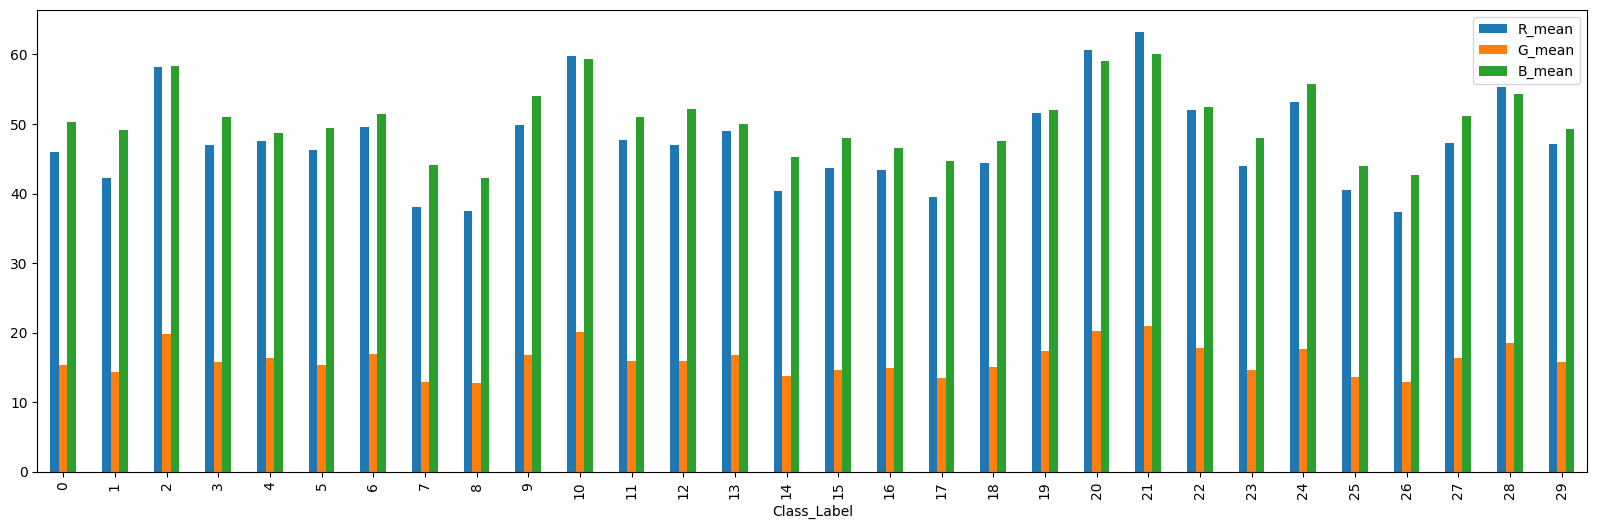

In [43]:
df.groupby("Class_Label").mean()[['R_mean', 'G_mean', 'B_mean']].plot(kind='bar', figsize=(20, 6))

<Axes: xlabel='Class_Label'>

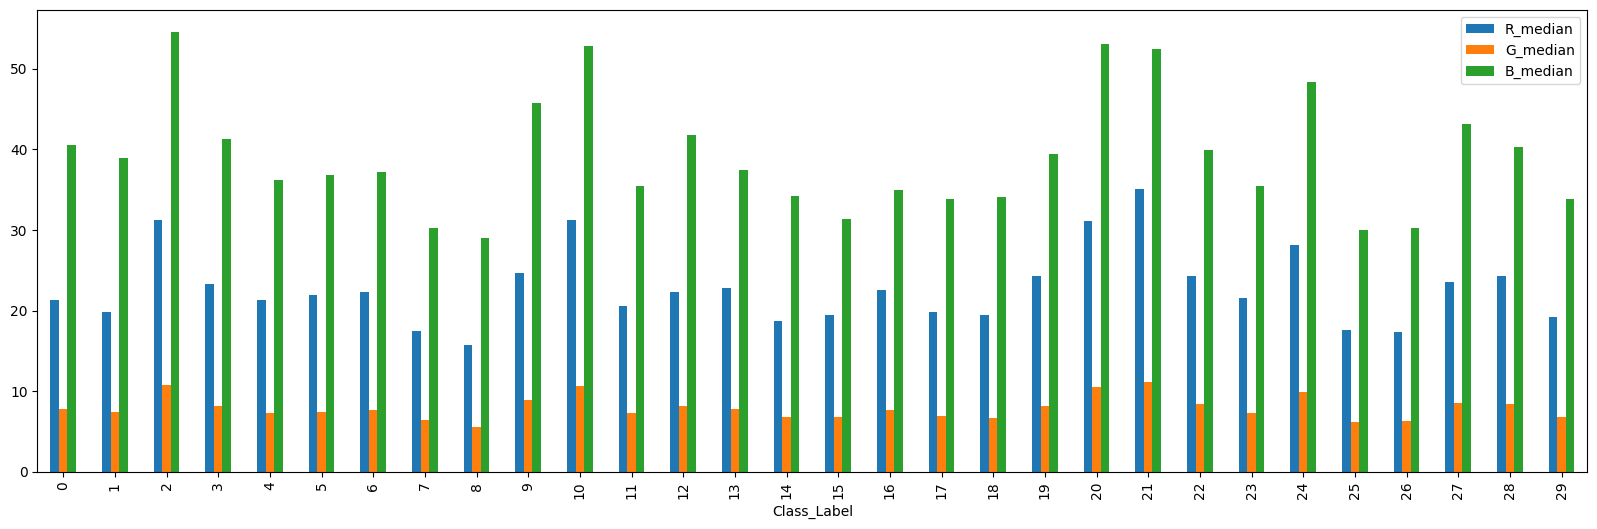

In [44]:
df.groupby("Class_Label").mean()[['R_median', 'G_median', 'B_median']].plot(kind='bar', figsize=(20, 6))

### After cleaning

In [45]:
image_files = glob.glob('../data/tsrc_spectrograms_cleaned/test/**/*.png')
df = pd.read_csv('../models/simple_cnn_tsrc_spectrograms/predictions.csv')
class_labels = df["y_true"].values

data = []

for img_file, label in tqdm(zip(image_files, class_labels), total=len(image_files)):
    img = Image.open(img_file).convert("RGB")
    img_array = np.array(img)
    
    r_mean = img_array[:, :, 0].mean()
    g_mean = img_array[:, :, 1].mean()
    b_mean = img_array[:, :, 2].mean()
    
    r_median = np.median(img_array[:, :, 0])
    g_median = np.median(img_array[:, :, 1])
    b_median = np.median(img_array[:, :, 2])

    data.append([r_mean, g_mean, b_mean, r_median, g_median, b_median, label])

df = pd.DataFrame(data, columns=["R_mean", "G_mean", "B_mean", "R_median", "G_median", "B_median", "Class_Label"])

for channel in ["R_mean", "G_mean", "B_mean", "R_median", "G_median", "B_median",]:
    corr, _ = pearsonr(df[channel], df["Class_Label"])
    print(f"Correlation between {channel} and Class_Label: {corr:.2f}")

100%|██████████| 14293/14293 [01:25<00:00, 167.85it/s]

Correlation between R_mean and Class_Label: 0.04
Correlation between G_mean and Class_Label: 0.04
Correlation between B_mean and Class_Label: -0.01
Correlation between R_median and Class_Label: 0.00
Correlation between G_median and Class_Label: -0.00
Correlation between B_median and Class_Label: -0.02


<Axes: xlabel='Class_Label'>

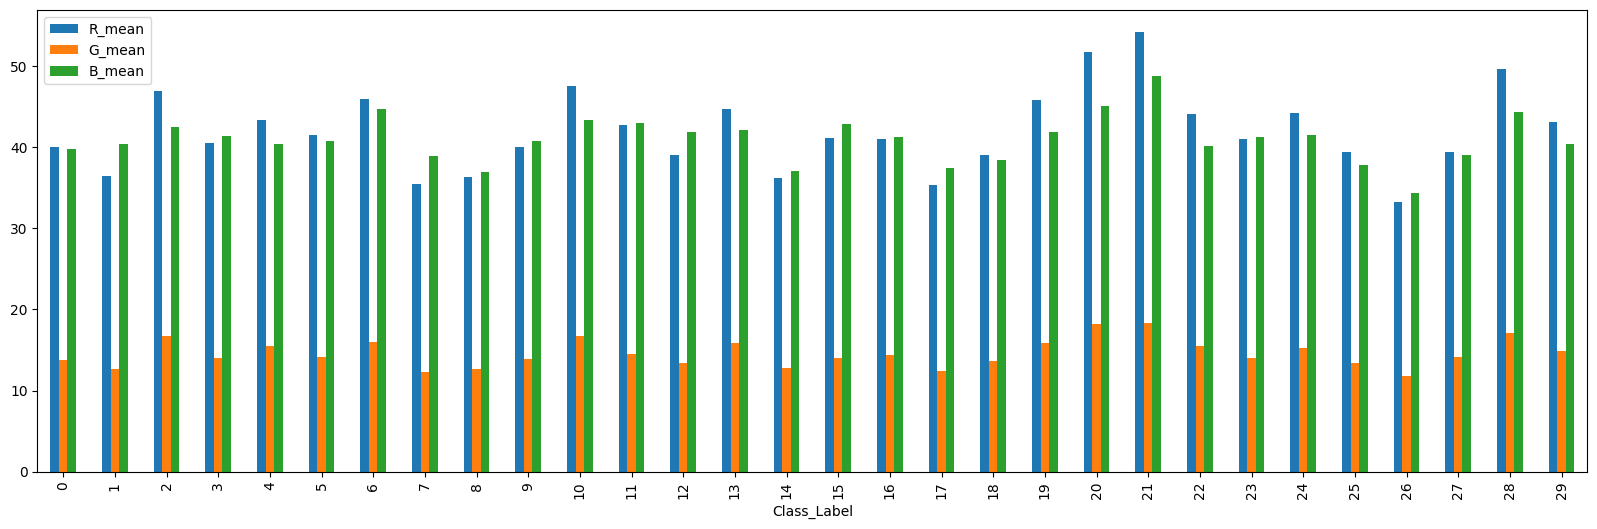

In [46]:
df.groupby("Class_Label").mean()[['R_mean', 'G_mean', 'B_mean']].plot(kind='bar', figsize=(20, 6))

<Axes: xlabel='Class_Label'>

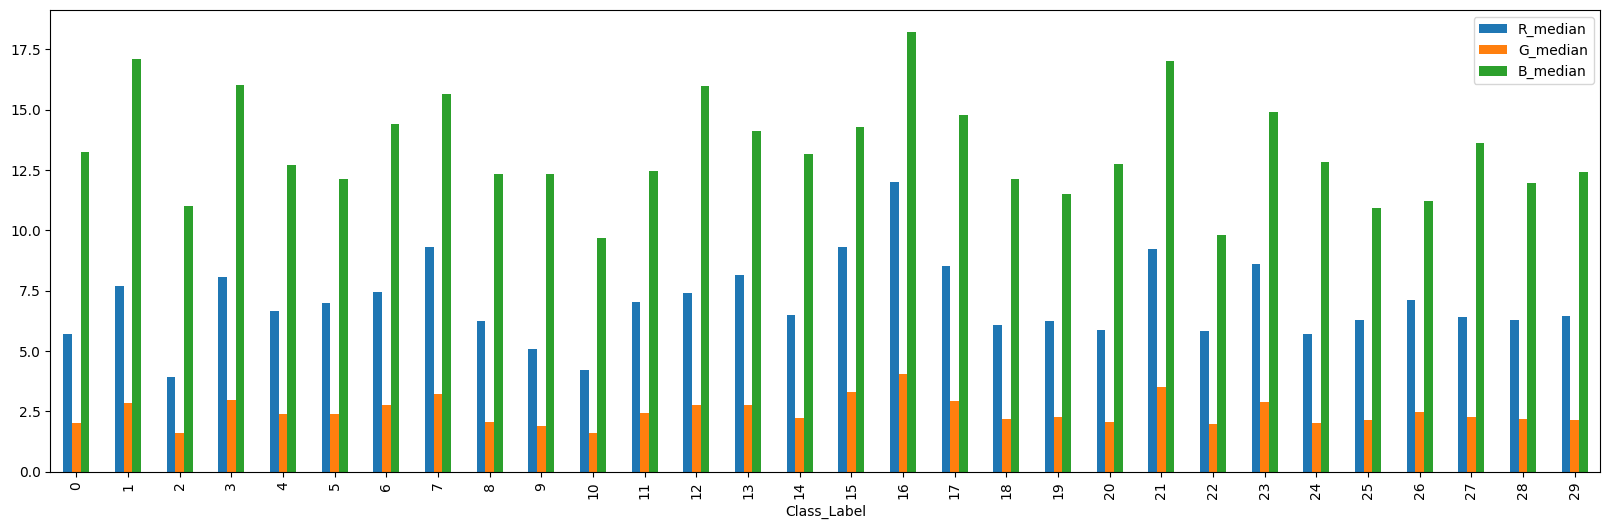

In [47]:
df.groupby("Class_Label").mean()[['R_median', 'G_median', 'B_median']].plot(kind='bar', figsize=(20, 6))

# Mean amplitude

## Raw audio

In [49]:
import numpy as np
import soundfile as sf

amplitudes = []

for audio_file in tqdm(glob.glob('../data/tsrc/train/audio/**/*.wav')):
    audio_file = Path(audio_file)
    word = audio_file.parent.stem

    if word == "_background_noise_":
        continue

    audio_data, sample_rate = sf.read(audio_file)
    mean_amplitude = np.mean(np.abs(audio_data))
    amplitudes.append([word, mean_amplitude])

df_amplitudes = pd.DataFrame(amplitudes, columns=["Word", "Mean_Amplitude"])

100%|██████████| 64727/64727 [04:35<00:00, 235.19it/s]


Text(0.5, 1.0, 'Mean Amplitude for raw audio')

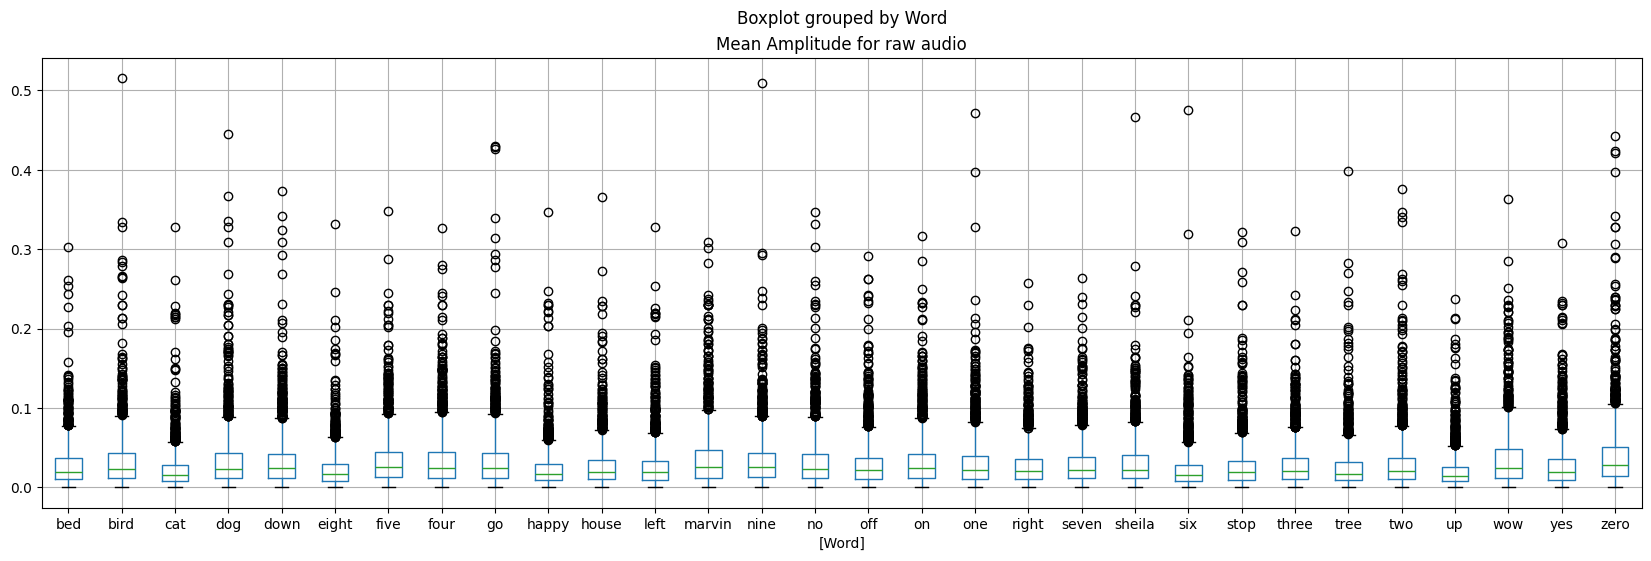

In [55]:
df_amplitudes.boxplot(by="Word", figsize=(20, 6))
plt.title("Mean Amplitude for raw audio")

## Cleaned audio

In [59]:
import numpy as np
import soundfile as sf

cleaned_amplitudes = []

for audio_file in tqdm(glob.glob('../data/tsrc_cleaned/**/**/*.wav')):
    audio_file = Path(audio_file)
    word = audio_file.parent.stem

    if word == "_background_noise_":
        continue

    audio_data, sample_rate = sf.read(audio_file)
    mean_amplitude = np.mean(np.abs(audio_data))
    cleaned_amplitudes.append([word, mean_amplitude])

df_cleaned_amplitudes = pd.DataFrame(amplitudes, columns=["Word", "Mean_Amplitude"])

100%|██████████| 64721/64721 [04:21<00:00, 247.17it/s] 


Text(0.5, 1.0, 'Mean Amplitude for cleaned audio')

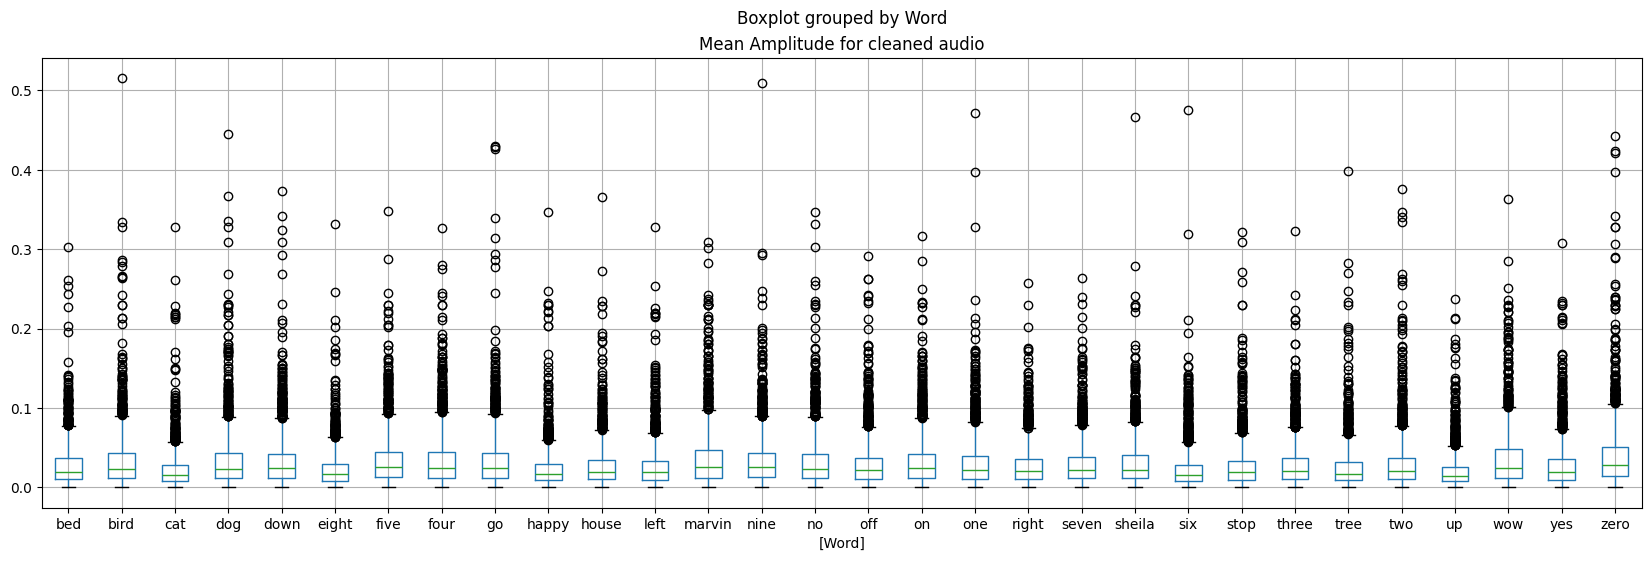

In [60]:
df_cleaned_amplitudes.boxplot(by="Word", figsize=(20, 6))
plt.title("Mean Amplitude for cleaned audio")